In [0]:
!pip install scprep

     |████████████████████████████████| 102kB 2.4MB/s 


In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import colors, cm

In [0]:
import pandas as pd
from scipy.spatial.distance import pdist, cdist, squareform

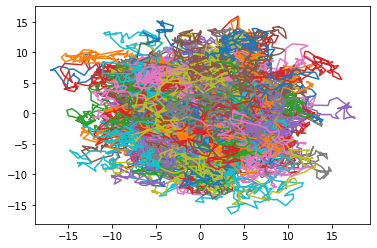

In [0]:
np.random.seed(1)
N0 = 200
T = 100
randomwalk = np.cumsum(np.random.normal(0, 1, (N0, T, 2)), axis=1)
initial_position = np.random.uniform(-10, 10, (N0, 2))[:,None]
randomwalk += initial_position
for t in range(T):
  randomwalk[:,t:] -= randomwalk[:,t:] * np.sqrt((randomwalk[:,t]**2).sum(1))[:,None,None] * 0.001
for i in range(N0):
  plt.plot(randomwalk[i][:,0], randomwalk[i][:,1])

In [0]:
lambda_s = 0.1736   #1/(days till severe case is hospitalised)
rho = 0.075         #1/(days in hospital)

In [0]:
N_death = 3
N_hospital = 20
N_test = 50
test_df = pd.DataFrame({
    'patient':np.random.choice(N0, N_test, replace=False),
    'date':np.random.choice(T, N_test, replace=True),
    'result':np.random.choice([True, False], N_test, p=[0.7, 0.3]),
})
hospital_patient = np.random.choice(test_df.loc[test_df['result']]['patient'], N_hospital, replace=False)
hospital_date = test_df.loc[np.isin(test_df['patient'], hospital_patient)]['date']
hospital_date += np.random.geometric(lambda_s, N_hospital)
hospital_df = pd.DataFrame({
    'patient':hospital_patient,
    'date':hospital_date,
})
death_patient = np.random.choice(hospital_df['patient'], N_death, replace=False)
death_date = hospital_df.loc[np.isin(hospital_df['patient'], death_patient)]['date']
death_date += np.random.geometric(rho, N_death)
death_df = pd.DataFrame({
    'patient':death_patient,
    'date':death_date,
})


In [0]:
location_df = pd.DataFrame({'patient':np.repeat(np.arange(N0), T),
                            'date':np.tile(np.arange(T), N0),
                            'latitude':randomwalk[:,:,0].flatten(),
                            'longitude':randomwalk[:,:,1].flatten()})

In [0]:
location_df

,patient,date,latitude,longitude
0,0,0,-2.245146,0.813738
1,0,1,-2.764336,-0.255947
2,0,2,-1.897354,-2.537493
3,0,3,-0.166531,-3.281504
4,0,4,0.148281,-3.515523
...,...,...,...,...
19995,199,95,-5.936190,-7.130280
19996,199,96,-5.566228,-7.135726
19997,199,97,-6.056172,-6.943595
19998,199,98,-5.445797,-6.413620


In [0]:
test_df

,patient,date,result
0,3,39,True
1,189,18,True
2,101,44,False
3,53,60,True
4,192,77,False
5,120,22,True
6,10,12,False
7,124,28,True
8,48,81,True
9,28,57,False


In [0]:
hospital_df

,patient,date
0,180,41
5,198,24
7,109,36
10,64,12
11,65,17
12,128,61
15,3,83
18,7,1
22,25,71
25,110,53


In [0]:
death_df

,patient,date
11,65,27
15,115,89
47,3,56


In [0]:
for patient in range(N0):
    patient_df = (
        location_df
        .loc[location_df["patient"] == patient]
        .sort_values("date")
    )
    for i in range(patient_df.shape[0] - 1):
        date = patient_df.iloc[i]["date"]
        if np.any(
            (death_df["patient"] == patient)
            & (death_df["date"] <= date)
        ):
            # dead
            color = "black"
        elif np.any(
            (hospital_df["patient"] == patient)
            & (hospital_df["date"] <= date)
        ):
            # hospitalized
            color = "red"
        elif np.any(
            (test_df["patient"] == patient)
            & (test_df["date"] <= date)
            & (test_df["result"])
        ):
            # tested positive
            color = "orange"
        elif np.any(
            (test_df["patient"] == patient)
            & (test_df["date"] <= date)
            & (~test_df["result"])
        ):
            # tested negative
            color = "green"
        else:
            color = "grey"
        plt.plot(
            patient_df.iloc[[i, i + 1]]["longitude"],
            patient_df.iloc[[i, i + 1]]["latitude"],
            color=color,
            alpha=0.5,
        )
plt.show()

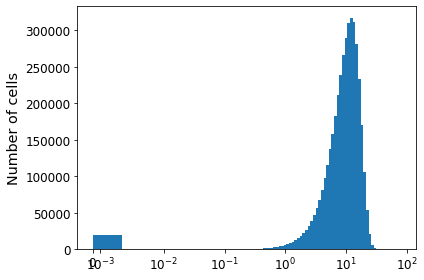

In [0]:
D = np.array([squareform(pdist(location_df.loc[location_df['date']==i][['longitude', 'latitude']]))
              for i in range(T)])
import scprep
scprep.plot.histogram(D.flatten(), log='x')

![schematic](https://covid-measures.github.io/model_schematic.png)

Parameters of interest: 

* $R_0$: number of expected secondary cases in a wholly susceptible population.
* $\gamma$: 1/time for which a patient is infectious
* $\beta_0 = R_0 \times \gamma$: transmissibility, or people infected by patient per day
* $\alpha$: percentage of cases that are asymptomatic
* $\lambda_p$: 1/time before symptoms appear
* $\lambda_a$: 1/time for asymptomatic to recover
* $\lambda_m$: 1/time for minorly symptomatic to recover
* $\lambda_s$: 1/time for severely symptomatic to be hospitalized
* $\rho$: 1/time for leaving hospital
* $\delta$: fraction of hospitalizations leading to death
* $\mu$: fraction of symptomatic cases which do not require hospitalization



Parameter estimates: 

* $1.6 < R_0 < 2.3$
* $\gamma = \frac{1}{7}$ or...
* $0.3299 < \beta_0 < 0.371$
* $0.308 < \alpha < 0.517$
* $\lambda_p = 2$
* $\lambda_a = 0.1429$
* $\lambda_m = 0.1429$
* $\lambda_s = 0.1736$
* $0.0689< \rho < 0.087$
* $0.14 < \delta < 0.33$
* $\mu = 0.956$

Sources: 
* [Marissa Childs, Morgan Kain, Devin Kirk, Mallory Harris, Jacob Ritchie, Lisa Couper, Isabel Delwel, Nicole Nova, Erin Mordecai](https://github.com/morgankain/COVID_interventions/blob/master/covid_params.csv)
* [Paige Miller, Pej Rohani, John Drake](http://2019-coronavirus-tracker.com/parameters-supplement.html)

### HMM Specification

Let $N_c$ be the average number of interactions each person has in a day, $N_0$ be the population, $N_i$ be the number of infectious people. Then naively,

$$P(E(t+1) | S(t)) = \frac{N_c N_i}{N_0}.$$

Note: we will actually determine this based on contacts with infected people. So

$$P(E(t+1) | S(t)) = 1 - \prod_{\text{patient }i}(1 - P(\text{contact with patient }i) P(\text{patient }i\text{ infectious})).$$

The probability of transmitting the disease on contact is

$$P(I_A(t+1) \text{ or } I_P(t+1) | E(t)) = \frac{\beta_0}{N_c}$$

and otherwise, a person remains susceptible

$$P(S(t+1) | E(t)) = 1-\frac{\beta_0}{N_c}.$$

We treat appearance of symptoms and recovery as geometrically distributed with $p = \frac{\lambda}{1+\lambda}$. So

$$P(I_P(t+1)|I_P(t)) = 1-\lambda_p$$
$$P(I_A(t+1)|I_A(t)) = 1-\lambda_a$$
$$P(I_M(t+1)|I_M(t)) = 1-\lambda_m$$
$$P(I_S(t+1)|I_S(t)) = 1-\lambda_s$$
$$P(H(t+1)|H(t)) = 1-\rho.$$

Finally, the remaining transition probabilities are defined as follows:

$$P(I_A(t+1) | I_A(t+1) \text{ or } I_P(t+1)) = \alpha$$

$$P(I_P(t+1) | I_A(t+1) \text{ or } I_P(t+1)) = 1 - \alpha$$

and 

$$P(I_M(t+1) | I_P(t) \text{ and not } I_P(t+1)) = \mu$$

$$P(I_S(t+1) | I_P(t) \text{ and not } I_P(t+1)) = 1 - \mu$$

and

$$P(D(t+1) | H(t) \text{ and not } H(t+1)) = \delta$$

$$P(R(t+1) | H(t) \text{ and not } H(t+1)) = 1-\delta.$$


In [0]:
state_dict = {0:'S', 1:'E', 2:'I_A', 3:'I_P', 4:'I_M', 5:'I_S', 6:'H', 7:'R', 8:'D'}
infectious_states = [2,3,4,5]

In [0]:
transitions = np.zeros((len(state_dict), len(state_dict)))

In [0]:
N_0 = len(patients) #starting number of infected cases
N_c = 4             #average number of contacts per day
beta0 = 0.35        #people infected by patient per day
alpha = 0.4         #fraction of cases that are asymptomatic
lambda_p = 1 # 2?   #1/(days till symptoms appear)
lambda_a = 0.1429   #1/(days till asymptomatic person recovers)
lambda_m = 0.1429   #1/(days till mild case recovers)
lambda_s = 0.1736   #1/(days till severe case is hospitalised)
rho = 0.075         #1/(days in hospital)
delta = 0.2         #number of deaths/number hospitalised
mu = 0.9#0.956      #fraction of symptomatic cases that don't need hospitalisation

### Meetings-based simulation

In [0]:
distance_cutoff = 1.5
def daily_contacts(patient, date):
    date_df = location_df.loc[location_df['date'] == date]
    patient_df = date_df.loc[date_df['patient'] == patient]
    if patient_df.shape[0] == 0:
      return []
    others_df = date_df.loc[date_df['patient'] != patient]
    contact = cdist(patient_df[['latitude', 'longitude']], 
                    others_df[['latitude', 'longitude']]) < distance_cutoff
    contact = contact.max(axis=0)
    contact_patients = others_df.iloc[contact]['patient'].to_numpy()
    return contact_patients

Nc = np.mean([len(daily_contacts(p, t)) for t in range(T) for p in range(N0)])
Nc

3.1087

In [0]:
patients = np.arange(N0)
dates = np.arange(T)
state = np.zeros((len(patients), len(state_dict)))
state[:, 0]=1
state.round(2)

N_i = np.sum(state[:,infectious_states])

transitions[0,0] = 1 - N_c * N_i / N_0 # S -> S
transitions[0,1] = N_c * N_i / N_0 # S -> E
transitions[1,0] = 1 - beta0 / N_c # E -> S
transitions[1,2] = alpha * beta0 / N_c # E -> I_A
transitions[1,3] = (1 - alpha) * beta0 / N_c # E -> I_P
transitions[2,2] = 1 - lambda_a # I_A -> I_A
transitions[2,7] = lambda_a # I_A -> R
transitions[3,3] = 1 - lambda_p # I_P -> I_P
transitions[3,4] = mu * lambda_p # I_P -> I_M
transitions[3,5] = (1-mu) * lambda_p # I_P -> I_S
transitions[4,4] = 1 - lambda_m # I_M -> I_M
transitions[4,7] = lambda_m # I_M -> R
transitions[5,5] = 1 - lambda_s # I_S -> I_S
transitions[5,6] = lambda_s # I_S -> H
transitions[6,6] = 1 - rho # H -> H
transitions[6,7] = (1 - delta) * rho # H -> R
transitions[6,8] = delta * rho # H -> D
transitions[7,7] = 1 # R -> R
transitions[8,8] = 1 # D -> D

transitions.round(3)

array([[1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.912, 0.   , 0.035, 0.052, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.857, 0.   , 0.   , 0.   , 0.   , 0.143, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.9  , 0.1  , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.857, 0.   , 0.   , 0.143, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.826, 0.174, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.925, 0.06 , 0.015],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]])

In [0]:
(death_df['patient'] == patient) & (death_df['date'] == date)

11    False
15    False
47    False
dtype: bool

In [0]:
def p_exposed(patient, date):
    contact_patients = daily_contacts(patient, date)
    if len(contact_patients) == 0:
      return 0
    p_contacts_infected = state[contact_patients][:,infectious_states].sum(1)
    p_exposed = 1 - np.prod(1 - p_contacts_infected)
    return p_exposed

for date in dates:
  next_state = state.copy()
  for patient in patients:
    if np.any((death_df['patient'] == patient) & (death_df['date'] == date)):
      # death
      next_state[patient] = np.zeros(len(state_dict))
      next_state[patient][8] = 1
    elif np.any((hospital_df['patient'] == patient) & (hospital_df['date'] == date)):
      # hospitalisation
      next_state[patient] = np.zeros(len(state_dict))
      next_state[patient][6] = 1
    elif np.any((test_df['patient'] == patient) & (test_df['date'] == date)):
      # positive test
      next_state[patient] = np.zeros(len(state_dict))
      next_state[patient][4] = mu
      next_state[patient][5] = 1 - mu
    else:
      # out in the world
      transitions[0, 1] = p_exposed(patient, date)
      transitions[0, 0] = 1 - transitions[0, 1]
      next_state[patient] = state[[patient]] @ transitions
  state = next_state
print(state.round(3))

[[0.    0.    0.    ... 0.002 0.978 0.02 ]
 [0.219 0.035 0.006 ... 0.003 0.719 0.008]
 [0.    0.    0.    ... 0.002 0.978 0.02 ]
 ...
 [0.194 0.014 0.005 ... 0.002 0.769 0.009]
 [0.    0.    0.    ... 0.003 0.798 0.199]
 [0.59  0.14  0.016 ... 0.004 0.221 0.002]]


In [0]:
with np.printoptions(threshold=np.inf):
  print(state.round(3))

[[0.    0.    0.    0.    0.    0.    0.002 0.978 0.02 ]
 [0.219 0.035 0.006 0.001 0.008 0.001 0.003 0.719 0.008]
 [0.    0.    0.    0.    0.    0.    0.002 0.978 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.287 0.57  0.143]
 [0.198 0.011 0.008 0.001 0.011 0.001 0.004 0.759 0.009]
 [0.444 0.007 0.001 0.    0.002 0.    0.001 0.538 0.006]
 [0.886 0.036 0.002 0.001 0.003 0.    0.001 0.071 0.001]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.198 0.002 0.004 0.    0.005 0.    0.002 0.779 0.009]
 [0.299 0.04  0.013 0.004 0.016 0.001 0.003 0.617 0.007]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.177 0.045 0.009 0.002 0.012 0.001 0.003 0.743 0.009]
 [0.153 0.085 0.01  0.002 0.013 0.001 0.003 0.725 0.008]
 [0.    0.    0.    0.    0.    0.    0.104 0.717 0.179]
 [0.173 0.009 0.003 0.001 0.005 0.    0.002 0.798 0.009]
 [0.672 0.006 0.002 0.001 0.003 0.    0.001 0.31  0.004]
 [0.282 0.011 0.007 0.001 0.011 0.001 0.004 0.676 0.008]
 [0.467 0.017 0.005 0.    0.007

In [0]:
# death rate
state[:,-1].mean()

0.020465155705183993